In [47]:
# %%!pip install transformers
# %pip install pymorphy2
# %pip install scikit-learn==1.4.2

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import pymorphy2
import string
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import WordCloud
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
posts = pd.concat([pd.read_csv('C:\\Users\\Dasha\\Desktop\\ВКР\\clean_data\\-112510789\\posts_0-30000.csv'),
                   pd.read_csv('C:\\Users\\Dasha\\Desktop\\ВКР\\clean_data\\-23482909\\posts_0-30000.csv'),
                   pd.read_csv('C:\\Users\\Dasha\\Desktop\\ВКР\\clean_data\\-25232578\\posts_0-30000.csv'),
                   pd.read_csv('C:\\Users\\Dasha\\Desktop\\ВКР\\clean_data\\-26284064\\posts_0-30000.csv'),
                   pd.read_csv('C:\\Users\\Dasha\\Desktop\\ВКР\\clean_data\\-40316705\\posts_0-30000.csv')])\
                   .drop('Unnamed: 0', axis = 1).drop_duplicates().dropna()



In [54]:
posts.reset_index(drop = True).iloc[12].text


'Два беспилотника-камикадзе атаковали нефтеперерабатывающую станцию в деревне Ерохино Тверской области. В здании повреждены крыша и стены и выбиты стёкла.\\n\\nПо нашей информации, первый БПЛА упал около трёх часов ночи, через 20 минут МВД ввело план "Крепость". В этот же момент на территории станции, рядом с маслоцехом, упал второй беспилотник и взорвался. Обошлось без пострадавших, оперслужбы быстро потушили пожар.'

C:\Temp\ipykernel_19680\2825084950.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


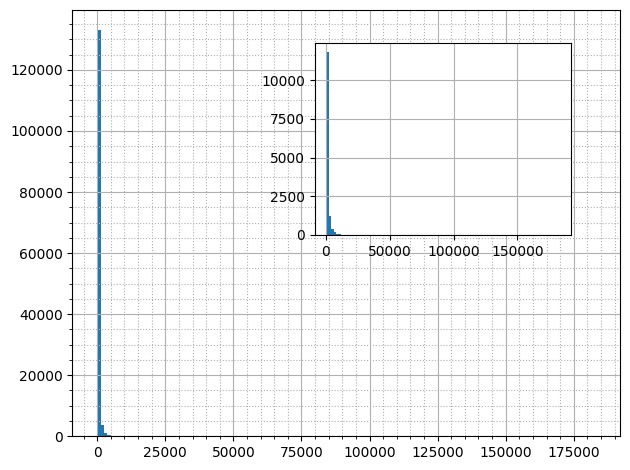

In [5]:
# Строим основную гистограмму
plt.hist(posts['likes'], bins = 150)
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

# Строим вторую гистограмму в отдельных осях
plt.axes([.5, .5, .4, .4])
plt.hist(posts['likes'], bins=100, stacked=True, range=(627, 182847))
plt.grid(which='major')

plt.tight_layout()

# сохраняем диаграмму в файл
plt.show()

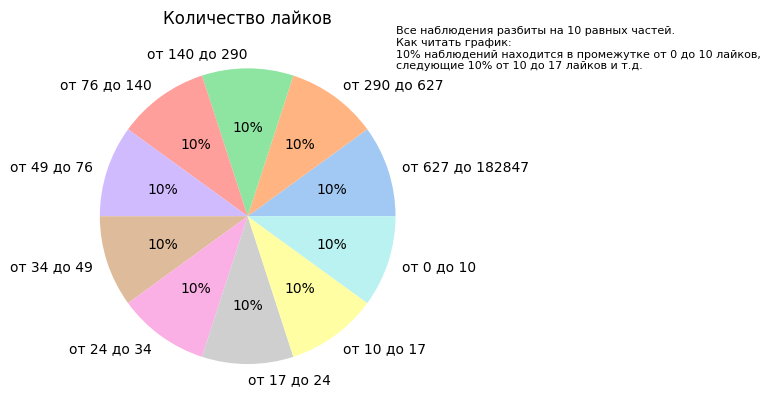

In [6]:
list_of_10_per = posts['likes'].describe([0, .1,.2, .3, .4, .5, .6, .7, .8, .9, 1])[4:-1].to_list()
lable_list = []
for i in range((len(list_of_10_per)) - 1):
  lable_list.append("от "+str(int(list_of_10_per[i])) + ' до ' + str(int(list_of_10_per[i+1])))

#define data
data = [10]*10
labels =lable_list[::-1]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.text(1, 1, 'Все наблюдения разбиты на 10 равных частей. \nКак читать график: \n10% наблюдений находится в промежутке от 0 до 10 лайков, \nследующие 10% от 10 до 17 лайков и т.д.', fontsize = 8)
plt.title('Количество лайков')
plt.show()

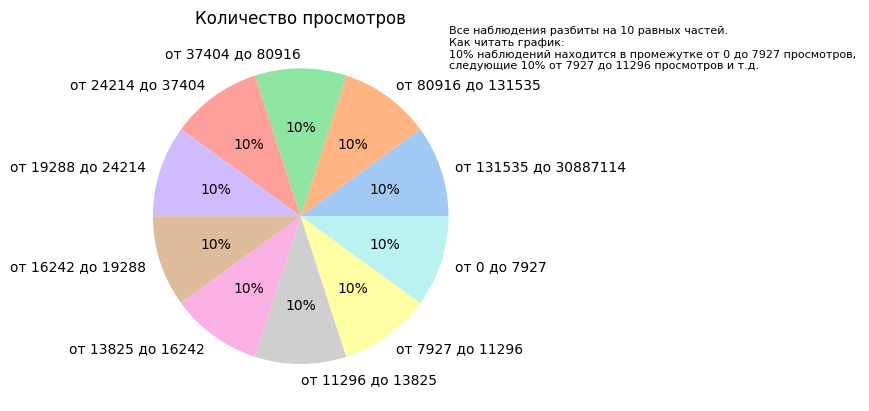

In [7]:
list_of_10_per = posts['views'].describe([0, .1,.2, .3, .4, .5, .6, .7, .8, .9, 1])[4:-1].to_list()
lable_list = []
for i in range((len(list_of_10_per)) - 1):
  lable_list.append("от "+str(int(list_of_10_per[i])) + ' до ' + str(int(list_of_10_per[i+1])))

#define data
data = [10]*10
labels =lable_list[::-1]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.text(1, 1, 'Все наблюдения разбиты на 10 равных частей. \nКак читать график: \n10% наблюдений находится в промежутке от 0 до 7927 просмотров, \nследующие 10% от 7927 до 11296 просмотров и т.д.', fontsize = 8)
plt.title('Количество просмотров')
plt.show()

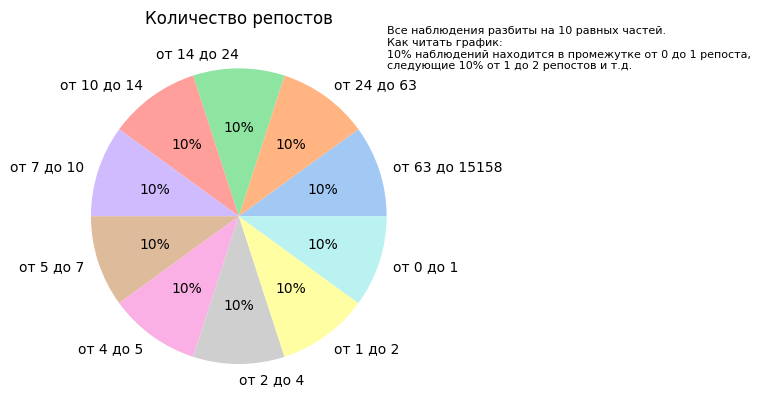

In [8]:
list_of_10_per = posts['reposts'].describe([0, .1,.2, .3, .4, .5, .6, .7, .8, .9, 1])[4:-1].to_list()
lable_list = []
for i in range((len(list_of_10_per)) - 1):
  lable_list.append("от "+str(int(list_of_10_per[i])) + ' до ' + str(int(list_of_10_per[i+1])))

#define data
data = [10]*10
labels =lable_list[::-1]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.text(1, 1, 'Все наблюдения разбиты на 10 равных частей. \nКак читать график: \n10% наблюдений находится в промежутке от 0 до 1 репоста, \nследующие 10% от 1 до 2 репостов и т.д.', fontsize = 8)
plt.title('Количество репостов')
plt.show()

In [9]:
rus_stopwords = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer(probability_estimator_cls=None)

In [10]:
def remove_stopwords(txt):
  s = ''
  txt = txt.strip()
  txt = txt.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
  txt = re.sub(r'[^\w\s]|\n', ' ', txt)
  txt = txt.lower()
  txt = re.sub('[^а-яА-ЯёЁ*\W]',' ',txt)
  for word in txt.split():
    word = morph.parse(word)[0].normal_form
    if word not in rus_stopwords:
      if word not in ['также', 'весь', 'это', 'который', 'иза', 'еще', 'ещё', 'ее', 'её', 'свой']:
        s = s+ word + ' '
  s = s[:-1]
  return s

In [11]:
# posts['text_norm'] = [remove_stopwords(i) for i in tqdm(posts['text'])]
posts = pd.read_csv('C:\\Users\\Dasha\\Desktop\\ВКР\\posts_norm.csv')

In [12]:
posts['конверсия'] =  (2*(posts.reposts.astype(float)) + posts.likes.astype(float)) / posts.views.astype(float)
posts['конверсия'] = posts['конверсия'].fillna(0)
posts.sort_values('конверсия').tail(5)

,id,owner_id,date,views,likes,reposts,text,text_norm,конверсия,len_text
135958,43638732,-40316705,1653559978,350561,19792,3819,В сети завирусилась речь британского епископа ...,сеть завируситься речь британский епископ рича...,0.078246,58
132311,45144079,-40316705,1663849380,199370,13148,2384,Толпы добровольцев в Чечне идут к военкоматам ...,толпа доброволец чечня идти военкомат объявить...,0.089863,10
136504,43389527,-40316705,1652094360,255504,21161,1354,"В Норильске, несмотря на метель, жители вышли ...",норильск несмотря метель житель выйти отпраздн...,0.093419,20
135495,43811107,-40316705,1654853750,334553,24545,3757,В небе над подмосковным Серпуховом самолётами ...,небо подмосковный серпухов самолёт написать ро...,0.095826,23
97336,4788459,-26284064,1670138128,19717,5240,4,Более 4 тыс. световых декоративных конструкций...,тыс светов декоративный конструкция украсить с...,0.266166,31


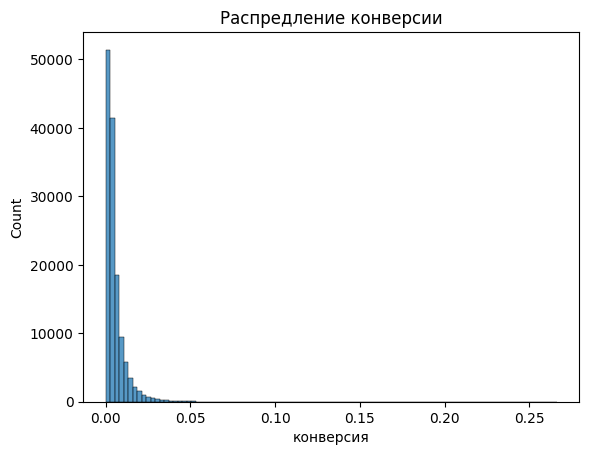

In [13]:
sns.histplot(data = posts, x = 'конверсия', bins = 100).set_title('Распредление конверсии')
plt.show()

In [14]:
posts['len_text'] = [len(i.split()) for i in posts['text_norm']]

In [15]:
posts = posts[posts['len_text'] >= 5]

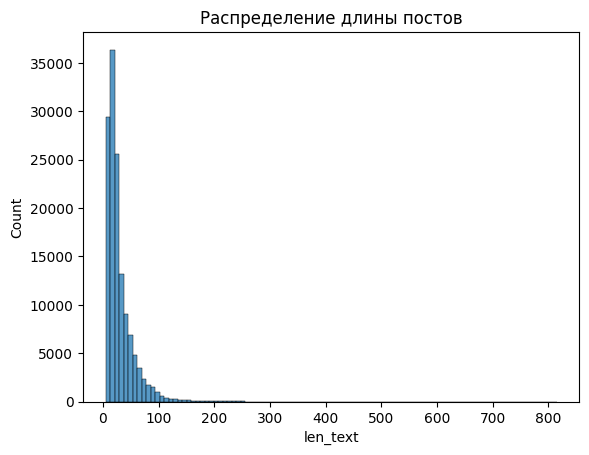

In [16]:
sns.histplot(data = posts, x = 'len_text', bins = 100).set_title('Распределение длины постов')
plt.show()

In [17]:
posts['len_text'].describe([.1,.25, .35, .5, .6, 0.7, .75, .8, .9, .95, .99])

count    137722.000000
mean         29.740906
std          24.654668
min           5.000000
10%           9.000000
25%          15.000000
35%          18.000000
50%          22.000000
60%          26.000000
70%          32.000000
75%          37.000000
80%          42.000000
90%          59.000000
95%          76.000000
99%         122.000000
max         815.000000
Name: len_text, dtype: float64

(-0.5, 399.5, 199.5, -0.5)

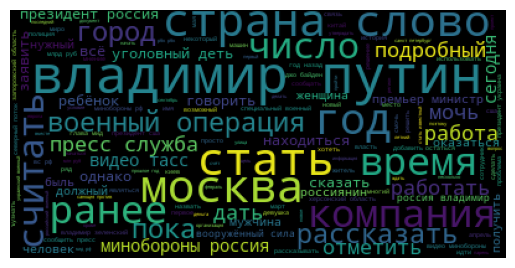

In [23]:
text = ' '.join(posts['text_norm'])

cloud = WordCloud().generate(text)
plt.imshow(cloud)
plt.axis('off')

In [24]:
posts

,id,owner_id,date,views,likes,reposts,text,text_norm,конверсия,len_text
0,8744340,-112510789,1685265676,33459,131,28,Простой турецкий избиратель голосует с барашко...,простой турецкий избиратель голосовать барашко...,0.005589,9
1,8744134,-112510789,1685262530,51586,61,53,Пожар случился в гастроцентре в московском Зар...,пожар случиться гастроцентр московский зарядье...,0.003237,23
2,8743208,-112510789,1685225026,387135,298,119,"Двигатель пассажирского судна ""Ривьера"" заглох...",двигатель пассажирский судный ривьера заглохну...,0.001385,34
3,8743056,-112510789,1685221807,89476,222,10,В возрасте 89 лет скончался советский художник...,возраст год скончаться советский художник конц...,0.002705,8
4,8742823,-112510789,1685218151,91366,151,92,"Губернатор Гладков попал под обстрел, когда пы...",губернатор гладков попасть обстрел пытаться въ...,0.003667,50
...,...,...,...,...,...,...,...,...,...,...
137717,42734741,-40316705,1649103060,66966,393,30,"«По телику показывали, что у нас армия е***ь к...",телик показывать армия е ь какать обученный те...,0.006765,29
137718,42732803,-40316705,1649098920,34759,184,8,«Бог кинематографистов»: 90 лет назад родился ...,бог кинематографист год назад родиться андрей ...,0.005754,46
137719,42732633,-40316705,1649098500,61463,244,32,О целях и задачах фейка в Буче в интервью RT D...,цель задача фейк буча интервью рассказать экс ...,0.005011,83
137720,42732282,-40316705,1649097720,39067,1247,90,"Экс-депутат Рады Кива — о том, что произошло в...",экс депутат рада кива произойти буча история б...,0.036527,26


(-0.5, 399.5, 199.5, -0.5)

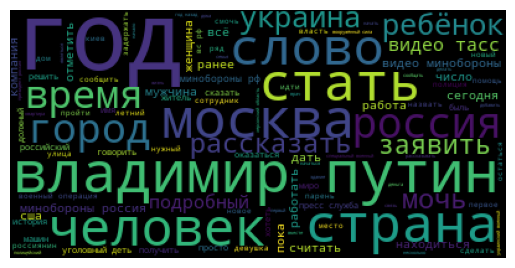

In [25]:
text = ' '.join(posts[posts['конверсия'] > 0.003523]['text_norm'])

cloud = WordCloud().generate(text)
plt.imshow(cloud)
plt.axis('off')

In [26]:
from nltk import ngrams
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
def get_dataframe_freq(n, text):
  def count_ngrams(tokens, n):
      ngrams_list = ngrams(tokens, n)
      return Counter(ngrams_list)

  tokens = nltk.word_tokenize(text.lower())
  ngram_freq = count_ngrams(tokens, n)
  df = pd.DataFrame(data = list(ngram_freq.items()), columns = ['n_gram', 'freq'])
  df = df.sort_values('freq')
  return df

In [28]:
n = 2
two_n_gramm_up = get_dataframe_freq(n, text)

In [29]:
n = 1
one_n_gramm_up = get_dataframe_freq(n, text)

In [30]:
n = 3
three_n_gramm_up = get_dataframe_freq(n, text)

(-0.5, 399.5, 199.5, -0.5)

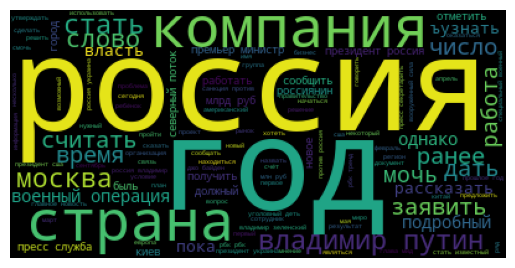

In [31]:
text = ' '.join(posts[posts['конверсия']<=0.003523]['text_norm'])

cloud = WordCloud().generate(text)
plt.imshow(cloud)
plt.axis('off')

In [32]:
n = 2
two_n_gramm_down = get_dataframe_freq(n, text)

In [33]:
n = 1
one_n_gramm_down = get_dataframe_freq(n, text)

In [34]:
n = 3
three_n_gramm_down = get_dataframe_freq(n, text)

In [21]:
pseq = posts['конверсия'].describe([0,.05, .1,.15,.2,.25, .3,.35, .4, .45,.5,.55, .6,.65, .7,.75, .8,.85 ,.9,.95, .99,1])

In [22]:
with open("UI_for_model\\analysis_base\\conversion.pickle", 'wb') as file_one:
    pickle.dump(pseq, file_one)

In [40]:
with open("UI_for_model\\analysis_base\\conversion.pickle", 'rb') as file_one:
    pseq = pickle.load(file_one)

In [41]:
pseq = pd.DataFrame(pseq).reset_index().iloc[4:-1]
pseq.head()

,index,конверсия
4,0%,0.000000
5,5%,0.000733
6,10%,0.001075
7,15%,0.001366
8,20%,0.001648


In [43]:
pseq[pseq['конверсия'] <= 0.005].iloc[-1]['index']

'65%'

In [36]:
# tokenizer = AutoTokenizer.from_pretrained('DARUSHKA2161/distilbert-base-multilingual-cased-vk-posts')
# model = AutoModelForSequenceClassification.from_pretrained('DARUSHKA2161/distilbert-base-multilingual-cased-vk-posts', num_labels = 1)
# model = model.to(device)

In [37]:
posts['likes/reposts'] = posts['likes']/posts['reposts']

<AxesSubplot:>

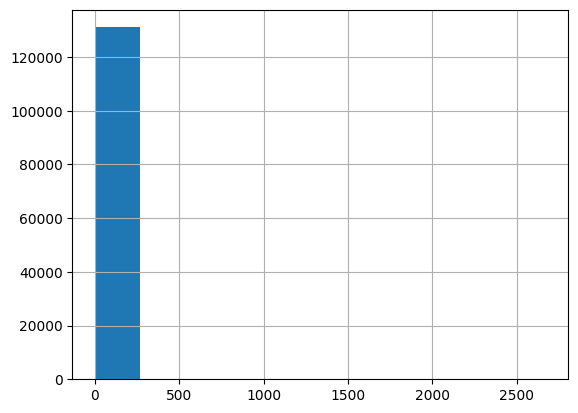

In [38]:
posts[posts['likes/reposts'].notna() & (posts['likes/reposts']!=float('inf'))]['likes/reposts'].hist()

In [39]:
posts[posts['likes/reposts'].notna() & (posts['likes/reposts']!=float('inf'))]['likes/reposts'].describe()

count    131186.000000
mean         16.420676
std          29.361662
min           0.000000
25%           3.000000
50%           7.000000
75%          19.550000
max        2672.000000
Name: likes/reposts, dtype: float64

In [108]:
one_n_gramm_up.freq = one_n_gramm_up.freq/sum(one_n_gramm_up.freq)
one_n_gramm_down.freq = one_n_gramm_down.freq/sum(one_n_gramm_down.freq)
one_n_gram = pd.merge(one_n_gramm_up.rename(columns = {'freq':'freq_up'}), one_n_gramm_down.rename(columns = {'freq':'freq_down'}), on = 'n_gram')
one_n_gram['freq_dif'] = one_n_gram.freq_down - one_n_gram.freq_up
one_n_gram.sort_values('freq_dif').tail(50)

,n_gram,freq_up,freq_down,freq_dif
35616,"(банка,)",0.000311,0.000802,0.000491
35920,"(основный,)",0.000530,0.001023,0.000493
36169,"(суд,)",0.001624,0.002118,0.000494
36123,"(начало,)",0.001095,0.001591,0.000496
35019,"(евросоюз,)",0.000164,0.000662,0.000498
36104,"(киев,)",0.000965,0.001473,0.000508
36127,"(число,)",0.001131,0.001640,0.000510
35578,"(фон,)",0.000294,0.000811,0.000517
35057,"(сделка,)",0.000169,0.000689,0.000520
35763,"(однако,)",0.000386,0.000907,0.000521


In [109]:
two_n_gramm_up.freq = two_n_gramm_up.freq/sum(two_n_gramm_up.freq)
two_n_gramm_down.freq = two_n_gramm_down.freq/sum(two_n_gramm_down.freq)
two_n_gram = pd.merge(two_n_gramm_up.rename(columns = {'freq':'freq_up'}), two_n_gramm_down.rename(columns = {'freq':'freq_down'}), on = 'n_gram')
two_n_gram['freq_dif'] = two_n_gram.freq_down - two_n_gram.freq_up
two_n_gram.sort_values('freq_dif').tail(50)

,n_gram,freq_up,freq_down,freq_dif
261489,"(глава, мид)",0.000265,0.000401,0.000136
259758,"(новость, ситуация)",0.000025,0.000161,0.000136
259879,"(начало, военный)",0.000026,0.000163,0.000136
259538,"(главное, тема)",0.000023,0.000161,0.000138
260265,"(ввести, санкция)",0.000032,0.000172,0.000140
261351,"(конец, год)",0.000112,0.000254,0.000142
258205,"(сегодня, деть)",0.000016,0.000158,0.000142
261079,"(собрать, главное)",0.000064,0.000209,0.000145
257267,"(цена, нефть)",0.000013,0.000161,0.000148
261165,"(материал, рбк)",0.000076,0.000224,0.000148


In [110]:
three_n_gramm_up.freq = three_n_gramm_up.freq/sum(three_n_gramm_up.freq)
three_n_gramm_down.freq = three_n_gramm_down.freq/sum(three_n_gramm_down.freq)
three_n_gram = pd.merge(three_n_gramm_up.rename(columns = {'freq':'freq_up'}), three_n_gramm_down.rename(columns = {'freq':'freq_down'}), on = 'n_gram')
three_n_gram['freq_dif'] = three_n_gram.freq_down - three_n_gram.freq_up
three_n_gram.sort_values('freq_dif').tail(50)

,n_gram,freq_up,freq_down,freq_dif
143468,"(президент, турция, реджеп)",3.689391e-05,0.000089,0.000052
143000,"(госсекретарь, сша, энтони)",1.791990e-05,0.000071,0.000053
143056,"(сша, энтони, блинкен)",1.897401e-05,0.000074,0.000055
142993,"(президент, франция, эмманюэль)",1.739284e-05,0.000073,0.000055
143006,"(франция, эмманюэль, макрон)",1.791990e-05,0.000074,0.000056
85848,"(украина, деть, й)",5.270559e-07,0.000058,0.000057
85849,"(россия, украина, деть)",5.270559e-07,0.000058,0.000057
143209,"(пакет, военный, помощь)",2.266340e-05,0.000080,0.000057
85850,"(происходить, ввод, войско)",5.270559e-07,0.000060,0.000059
143331,"(фон, дер, ляйена)",2.793396e-05,0.000088,0.000060


In [111]:
import pickle
with open("UI_for_model\\analysis_base\\one_n_gram.pickle", 'wb') as file_one:
    pickle.dump(one_n_gram, file_one)

with open("UI_for_model\\analysis_base\\two_n_gram.pickle", 'wb') as file_one:
    pickle.dump(two_n_gram, file_one)

with open("UI_for_model\\analysis_base\\three_n_gram.pickle", 'wb') as file_one:
    pickle.dump(three_n_gram, file_one)

In [115]:
posts['text'][0]

'Простой турецкий избиратель голосует с барашком на поводке. За кого — не знаем, но перформанс со смыслом'

In [116]:
import pickle
with open("UI_for_model\\analysis_base\\one_n_gram.pickle", 'rb') as file_one:
    one_n_gram = pickle.load(file_one)

with open("UI_for_model\\analysis_base\\two_n_gram.pickle", 'rb') as file_one:
    two_n_gram = pickle.load(file_one)

with open("UI_for_model\\analysis_base\\three_n_gram.pickle", 'rb') as file_one:
    three_n_gram = pickle.load(file_one)

In [134]:
get_down= pd.concat([one_n_gram.sort_values('freq_dif').tail(100),
            two_n_gram.sort_values('freq_dif').tail(100),
            three_n_gram.sort_values('freq_dif').tail(100)])

get_up = pd.concat([one_n_gram.sort_values('freq_dif').head(100),
            two_n_gram.sort_values('freq_dif').head(100),
            three_n_gram.sort_values('freq_dif').head(100)])

In [135]:
text_frame = pd.concat([get_dataframe_freq(1, posts['text_norm'][0]), get_dataframe_freq(2, posts['text_norm'][0]), get_dataframe_freq(3, posts['text_norm'][0])])

In [143]:
n_grams_up = pd.merge(get_up, text_frame, on = 'n_gram')
set_up_word = set()
for item in n_grams_up.n_gram:
    set_up_word = set_up_word|set(item)
set_up_word

{'знать'}

In [138]:
n_grams_down = pd.merge(get_down, text_frame, on = 'n_gram')
set_down_word = set()
for item in n_grams_down.n_gram:
    set_down_word = set_down_word|set(item)
set_down_word

set()

In [157]:
finish_str = ''
for post_text in posts['text'][0].split():
    post_text_cut=re.sub(r'[^\w\s]|\n', '',post_text)
    if morph.parse(post_text_cut)[0].normal_form in set_up_word:
        finish_str = finish_str+'<span class="green-box">' + post_text + '</span>' +' '
    elif morph.parse(post_text_cut)[0].normal_form in set_down_word:
        finish_str = finish_str+'<span class="pink-box">' + post_text + '</span>' +' '
    else:
        finish_str = finish_str+'<span class="info-value">' + post_text + '</span>' +' '

In [160]:
finish_str[:-1]

'<span class="info-value">Простой</span> <span class="info-value">турецкий</span> <span class="info-value">избиратель</span> <span class="info-value">голосует</span> <span class="info-value">с</span> <span class="info-value">барашком</span> <span class="info-value">на</span> <span class="info-value">поводке.</span> <span class="info-value">За</span> <span class="info-value">кого</span> <span class="info-value">—</span> <span class="info-value">не</span> <span class="green-box">знаем,</span> <span class="info-value">но</span> <span class="info-value">перформанс</span> <span class="info-value">со</span> <span class="info-value">смыслом</span>'

In [46]:
strin = 'Спикер Госдумы Вячеслав Володин не исключил, что может состояться еще одно внеочередное пленарное заседание Думы:\\nhttp://go.tass.ru/jnCrs'
strin.replace('\\n', ' ')

'Спикер Госдумы Вячеслав Володин не исключил, что может состояться еще одно внеочередное пленарное заседание Думы: http://go.tass.ru/jnCrs'